In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from FrozenLake import *
from CurriculumPPO import CurriculumPPO

In [2]:
is_slippery = False
reward_shape = True
dense_reward = True
num_bins = 0
nrows = 30

num_runs = 3
episodes = 16900000
checkpoint_step=1000000
test_episodes = 1000

shape_range=(-1,0)
goal_reward = 1.
debug = False
param_decay=False

lam = 0.95
experiment_results = []
exp_taus = []
tests_returns = []
tests_lens = []
exp_taus = []

In [3]:
if num_bins == 0:
    reward_shape = dense_reward = False
    discount_tau = True
else:
    reward_shape = dense_reward = True
    discount_tau = False

In [4]:
#Frozen Lake Environment
tau = 0.
nS = nrows**2
nA = 4
gamma = 0.99999999
xi = np.ones(nS) * 1/nS

In [5]:
entropy_coef = 0.0010124439030950623
pol_lr = 0.009134440173746728
model_lr = 0.009639507027402032
temp = 36
epochs= 7

batch_size = 60
final_temp=1e-1

eps_ppo = 0.28
eps_model = compute_eps_model(gamma, tau, episodes/10)

In [6]:
run_name = f"PPO_{num_bins}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [7]:
def run_experiment(index, seed, run_name, change_map=False):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        # Environment specific configuration   
        map_seed = seed if change_map else constants.SEEDS[0]
        set_policy_seed(seed)
        env = FrozenLakeEnv(is_slippery=is_slippery, seed=seed, 
                        desc=generate_random_map(nrows, seed=map_seed), 
                        reward_shape=reward_shape,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, 
                    gamma=gamma, discount_tau=discount_tau, 
                    seed=seed)
        tmdp.update_tau(tau)
        curr_PPO = CurriculumPPO(tmdp, checkpoint_step=checkpoint_step)

        curr_PPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_model=eps_model,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef, debug=debug)
        
        
        avg_return = np.average(curr_PPO.reward_records[-10:])/batch_size
        
        
        mlflow.log_metric("Avg Return", avg_return)     

        test_policies = test_policies_len(tmdp, curr_PPO.thetas, test_episodes, 1e-10)
        test_policies_return = test_policies[0]
        test_pol_len = test_policies[1]
        
        result_dict = {
            "thetas" : curr_PPO.thetas,
            "taus" : curr_PPO.taus,
            "reward_records" : curr_PPO.reward_records,
            "test_policies_return" : test_policies_return,
            "index" : index,
            "test_pol_len" : test_pol_len,
        }

        tests_returns.append(test_policies_return)
        experiment_results.append(result_dict)
        tests_lens.append(test_pol_len)
        exp_taus.append(curr_PPO.taus)

In [8]:
def run_experiments(change_map=False, num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name, change_map)
        
        pad_returns = pad_to_same_length(tests_returns)
        pad_lens = pad_to_same_length(tests_lens)
        pad_taus = pad_to_same_length(exp_taus)

        experiment_dict = {
            "tests_returns": pad_returns,
            "taus": pad_taus,
            "tests_lens": pad_lens,
            "num_runs": num_runs,
            "change_map": change_map,
            "num_bins": num_bins,
            "label": label,
            "checkpoint_step": checkpoint_step,
        }

        mlflow.set_tags(tags={
            "change_map": change_map,
            "seed": seed,
            "tau": tau,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "dense_reward": dense_reward,
            "shape_range": shape_range,
            "goal_reward": goal_reward,
            "reward_shape": reward_shape,
            "episodes": episodes,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "temp": temp,
            "final_temp": final_temp,
            "batch_size": batch_size,
            "epochs": epochs,
            "lam": lam,
            "eps_ppo": eps_ppo,
            "eps_model": eps_model,
        })

        try:
            save_to_mlflow(experiment_dict, run_name)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_returns, f"PPO Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Current seed for result reproducibility: 2999
Episode: 10000000 reward: 0.0 tau 0.0
Sampling loop is over. Done flag: False, Terminated flag: True
Current seed for result reproducibility: 58864
Episode: 10000000 reward: 0.0 tau 0.0
Sampling loop is over. Done flag: False, Terminated flag: True
Current seed for result reproducibility: 29859
Episode: 10000000 reward: 0.0 tau 0.0
Sampling loop is over. Done flag: False, Terminated flag: True
Dictionary saved at ./results.pth
Dictionary saved to MLflow and local file removed


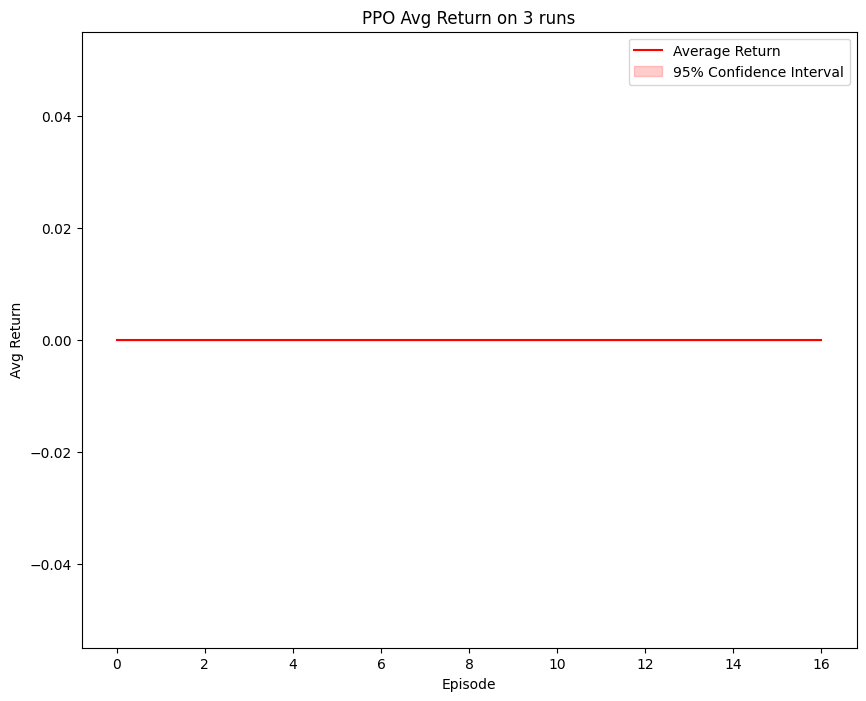

In [9]:
run_experiments(change_map=False, num_runs=num_runs)

In [10]:
map_seed = seed = SEEDS[0]
set_policy_seed(seed)
env = FrozenLakeEnv(is_slippery=is_slippery, seed=seed, 
                desc=generate_random_map(nrows, seed=map_seed), 
                reward_shape=reward_shape,
                num_bins=num_bins,
                dense_reward=dense_reward,
                shape_range=shape_range,
                goal_reward=goal_reward,
                )

# Environment independent configuration
tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)
tmdp.update_tau(tau)

Current seed for result reproducibility: 2999


In [11]:
pi = get_softmax_policy(experiment_results[2]["thetas"][-1], 1e-30)


In [12]:

tmdp.update_tau(0.)
tmdp.reset()
done = False
step = 0
env.render_mode = "human"
while True:
    s = tmdp.env.s
    a = select_action(pi[s])
    s_prime, reward, flags, prob = tmdp.step(a)
    print("state {} action {} next state {} reward {}".format(s, a, s_prime, reward))
    if flags["done"]:
        tmdp.reset()
        break
    step +=1
    if step > min(100,nrows*3):
        break


state 0 action 2 next state 1 reward 0.0
state 1 action 1 next state 31 reward 0.0
state 31 action 1 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 action 0 next state 60 reward 0.0
state 60 action 2 next state 61 reward 0.0
state 61 actio